# III - Data Analysis with ChiVO


## What is JOVIAL

Jovial is a webapp for programming-oriented astronomical data analysis:
* It is basically a cloud environment based on Jupyter Notebooks (python)
* No installation required! (for the on-line version)
* Brings computations where the data is (data centers)

The current JOVIAL status is alpha, but we are moving to beta today! 
* Not all the planned functionalities are available
* The service might be unstable due to heavy development
* We need to improve connectivity to archives or replicate more data

## How it works

Jovial is a user-based service:
* Jovial allocates a special workspace for the user, and runs a light-weighted virtual machine dedicated to the user.
* You can run console and python scripts, but we strongly recommend using Notebooks!
* Parallel computations are possible right now using the computing nodes of the data center, but there is no easy-to-use interface yet (WIP).


In [ ]:
# pip install acalib

In [1]:
import os
import urllib.request
import tarfile
import sys

global DOWNLOADS_DIR 
DOWNLOADS_DIR= '.'

def download_and_extract(url):
    # Obtain the filename
    name = url.rsplit('/', 1)[-1]
    filename = os.path.join(DOWNLOADS_DIR, name)
    # Download the file if not found
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
    # Decompress (if needed) and copy the selected file to the DOWNLOADS_DIR
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    if not os.path.isdir(sdir):
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()

In [2]:
m100_url='https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz'
download_and_extract(m100_url)

In [3]:
!ls M100_Band3_ReferenceImages

M100-CO.mom0.fits    M100-CO_map.png      M100line.image.fits
M100-CO.mom1.fits    M100-CO_velfield.png
M100-CO_contmap.png  M100cont.image.fits


In [4]:
from astropy.io import fits
import logging
import warnings
warnings.filterwarnings('ignore')

# Load File
hdulist = fits.open("M100_Band3_ReferenceImages/M100line.image.fits")
m100_hdu = hdulist[0]

## ACALib

ACALib is a ChiVO library for advanced computing for astronomical data. The stable version can be installed using ``pip``, the development version can be found at [github](https://github.com/ChileanVirtualObservatory/acalib) and the documentation is at [ReadTheDocs](http://acalib.readthedocs.io/en/latest/)

### NDData and Table
ACALib uses Astropy's Tables and N-Dimensional Data classes for all operations. 
Then, our first step is to convert from a fits file to the NDData object.

In [5]:
import acalib as aca
cube=aca.HDU_to_NDData(m100_hdu)
(cube,a,b) = aca.standarize(cube)

ImportError: No module named 'acalib'

## User Programmatic Interface (UPI)

In [7]:
aca.axes_names(cube)

array(['FREQ', 'DEC', 'RA'], 
      dtype='<U4')

In [8]:
aca.axes_units(cube)

array([Unit("Hz"), Unit("deg"), Unit("deg")], dtype=object)

In [9]:
aca.extent(cube)

(array([<Quantity 114587503125.0 Hz>, <Quantity 15.777773482289602 deg>,
        <Quantity 185.77204798519327 deg>], dtype=object),
 array([<Quantity 114743753125.0 Hz>, <Quantity 15.861106821199073 deg>,
        <Quantity 185.6854341680921 deg>], dtype=object))

In [10]:
aca.center(cube)

array([<Quantity 114587503125.0 Hz>, <Quantity 15.81944444444 deg>,
       <Quantity 185.72875 deg>], dtype=object)

In [33]:
cube.data.shape

(40, 600, 600)

In [11]:
subcube=aca.cut(cube,lower=(20,250,250),upper=(30,350,350))

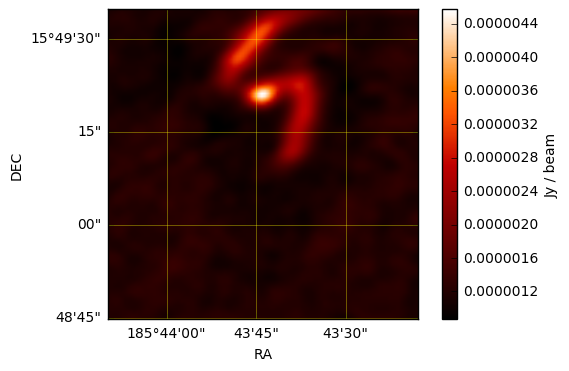

In [12]:
aca.visualize(aca.moment0(subcube))

### Noise Selector

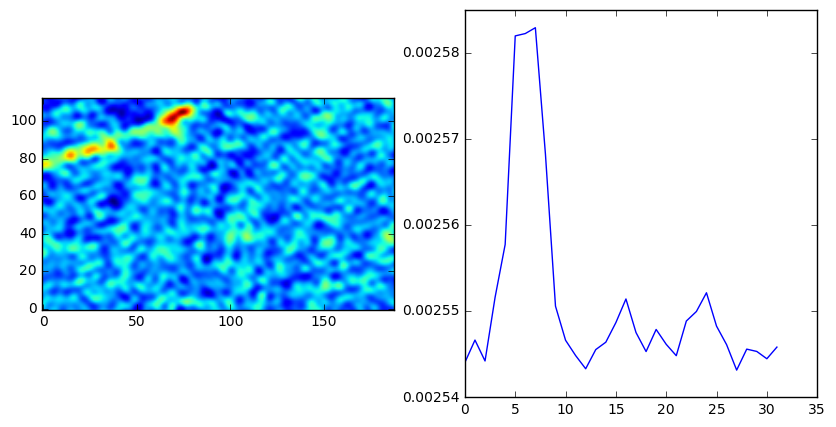

In [13]:
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt


ra_max   = cube.meta['NAXIS1']
dec_max  = cube.meta['NAXIS2']
spec_max = cube.meta['NAXIS3']

def cut_and_show(rlow=0,rhigh=ra_max,
                 dlow=0,dhigh=dec_max,
                 slow=0,shigh=spec_max):
    tmp=cube.data[slow:shigh,dlow:dhigh,rlow:rhigh]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(np.nansum(tmp,axis=(0)),origin='lower')
    plt.subplot(1,2,2)
    plt.plot(np.nansum(tmp,axis=(1,2)))
    plt.show()

res=interact(cut_and_show,
             rlow=(0,ra_max), rhigh=(0,ra_max),
             dlow=(0,dec_max),dhigh=(0,dec_max),
             slow=(0,spec_max),shigh=(0,spec_max))

In [14]:
limits=res.widget.kwargs

In [15]:
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
noisecube = aca.cut(cube,lower=lower,upper=upper)

In [16]:
noise_level=aca.noise_level(noisecube)
(noise_level.value*a+b)*noise_level.unit

<Quantity 0.0005989994026332074 Jy / beam>

### Thresholding

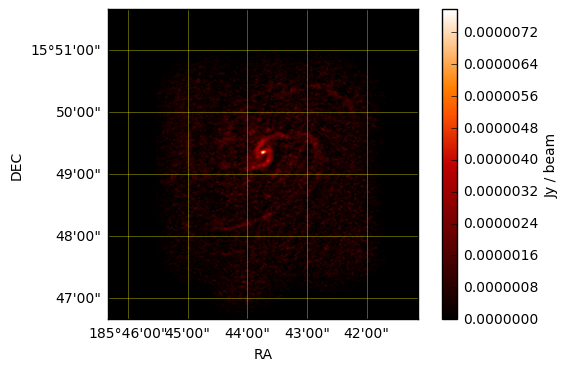

In [17]:
dencube=aca.denoise(cube,threshold=1.1*noise_level)
aca.visualize(aca.moment0(dencube))

### Clumpfind

In [11]:
algo=aca.algorithms.ClumpFind()
algo.config['RMS']=aca.noise_level(cube).value
cf_res=algo.run(cube)

In [12]:
(caa,pix)=cf_res

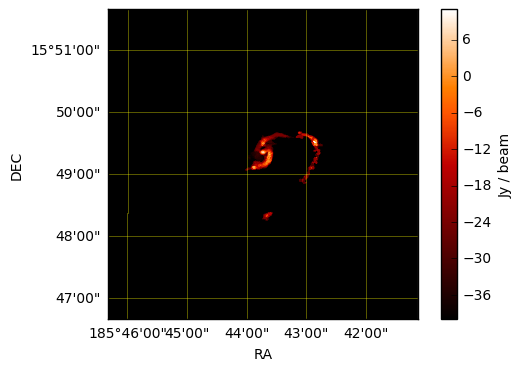

In [13]:
aca.visualize(aca.moment0(caa))

In [46]:
# Plot clumpfind

dict_keys([1, 66, 69, 70, 65, 8, 11, 76, 80, 81, 82, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 39, 43, 48, 56, 58, 60, 61, -1])

In [61]:
# Indexing

In [47]:
algo=aca.algorithms.Indexing()
in_res=algo.run(cube)

(40, 600, 600)


In [ ]:
#Stacking

In [ ]:
plt.figure()
syn2D=syn.sum(axis=(0))
vm=syn2D.max()
plt.subplot(121)
plt.imshow(syn2D,vmin=0,vmax=vm,origin='lower')
plt.subplot(122)
plt.imshow(res.sum(axis=(0)),vmin=0,vmax=vm,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
from sompy.sompy import SOMFactory
newRep=rep['center'].data
sm = SOMFactory().build(newRep, normalization = 'var', initialization='pca')
sm.train(n_job=1, verbose=False, train_rough_len=30, train_finetune_len=30)

In [ ]:
sm.codebook.matrix

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
def show_manifold(sm):
    cbook=sm.codebook.matrix
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cbook[:,0],cbook[:,1], cbook[:,2],c=cbook[:,0])#, c=c, marker=m)
    for cb,dm_elm in zip(cbook,sm._distance_matrix):
        conn=(dm_elm==1).nonzero()
        for idx in conn[0]:
            ot=cbook[idx]
            ax.plot([cb[0],ot[0]],[cb[1],ot[1]],[cb[2],ot[2]],color = 'Grey',alpha=0.5)
    plt.show()
show_manifold(sm)